# Example Notebook 2: Tension extraction

This notebook demonstrates how to extract tension from any given piece using the toolbox MusTen. 

In [4]:
%matplotlib inline
from __future__ import print_function

import librosa.display
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import seaborn as sns
from scipy.ndimage.filters import uniform_filter1d


import dissonant
import os
import scipy
import pandas as pd

import import_ipynb
from scipy import stats
import spleeter

from pydub import AudioSegment
import soundfile
from scipy.signal import savgol_filter
from scipy import signal
import scipy.signal

from scipy.stats import spearmanr

### Importing our custom functions

In [2]:
%run tension_functions.ipynb     #defining our custom functions


### 1. Importing and trimming the audio file


This function will load the audio as well as cut away silence in the beginning and in the end. This trimmed version will be saved as a new audio file in the music directory.

In [3]:
file_name = "Mozart"
inpath = "../music_files/"
outpath = "./music_trim/"
sr = 44100

y,sr,trimmed_audio_path = music_loading(file_name, inpath, outpath, sr)

../music_files/Mozart.wav


### 2. Extracting the features

Here, we extract the features from our audio. For a more detailed view on the feature extraction, see example notebook 1.

The features include:
- Tempo
- Loudness
- Dissonance
- Pitch Height
- Onset frequency

In [4]:
df_all_features, pitch_df, onset_env = feature_extraction(y, sr, trimmed_audio_path)


Estimating tempo...
Estimating Onset frequency...
Estimating loudness...
Estimating Pitch...
Estimating polyphone pitch using Deep Salience
Computing HCQT...
Computing salience...
   > 1 / 9
1/1 [==============================] - 5s 5s/step
   > 2 / 9
1/1 [==============================] - 5s 5s/step
   > 3 / 9
1/1 [==============================] - 7s 7s/step
   > 4 / 9
1/1 [==============================] - 6s 6s/step
   > 5 / 9
1/1 [==============================] - 6s 6s/step
   > 6 / 9
1/1 [==============================] - 7s 7s/step
   > 7 / 9
1/1 [==============================] - 7s 7s/step
   > 8 / 9
1/1 [==============================] - 7s 7s/step
   > 9 / 9
1/1 [==============================] - 5s 5s/step
Saving output...
Estimating dissonance...


### 3. Tension prediction

Here, we will predict the tension from our features. Therefore, we will first smooth and resample the features and then submit them into the tension model.

In [5]:
#This function returns the smoothed and the unsmoothed features sampled at 10 Hz 
#We will use the smoothed features going further
df_features, features_unsmoothed = feature_smoothing_resampling(df_all_features)



Predicting the tension with the weighted prediction model using the our optimal weights. 

The tension prediction function returns: 
- One dataframe with our tension prediction and the time
- One dataframe with the slopes for every feature

We then compare the two model predictions with the feature slopes estimated by both model variants. 

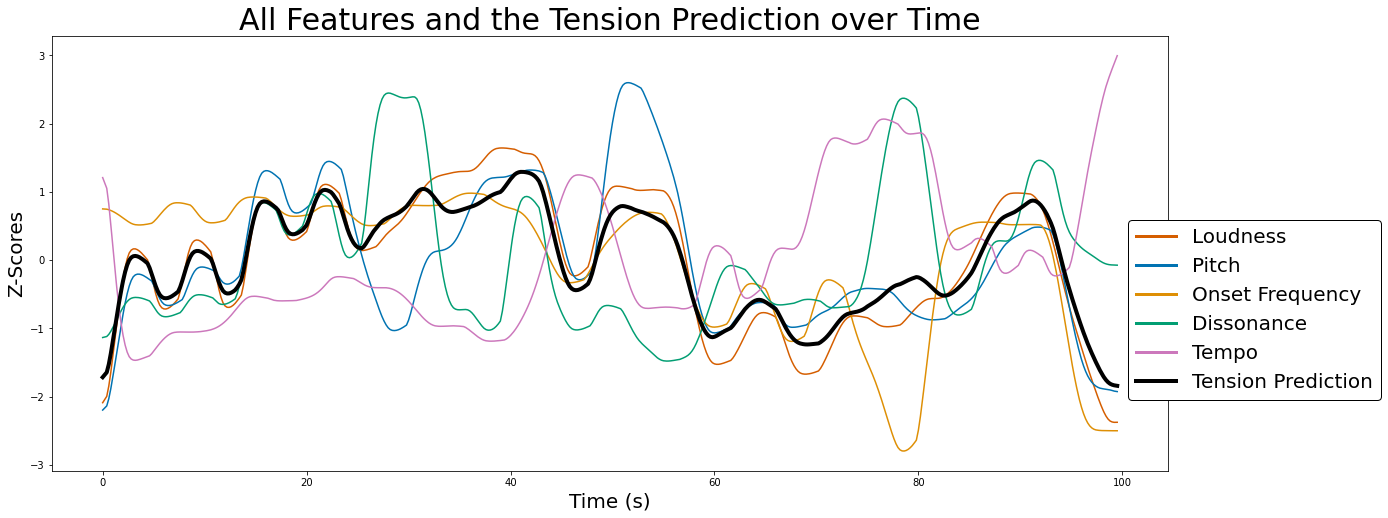

In [6]:
###Weighted model
tension_weights, feature_slopes = tension_prediction(df_features, model_variant = "weight")

plot_tension_and_features_10Hz(tension_weights, feature_slopes)

And extracting tension with the window model.

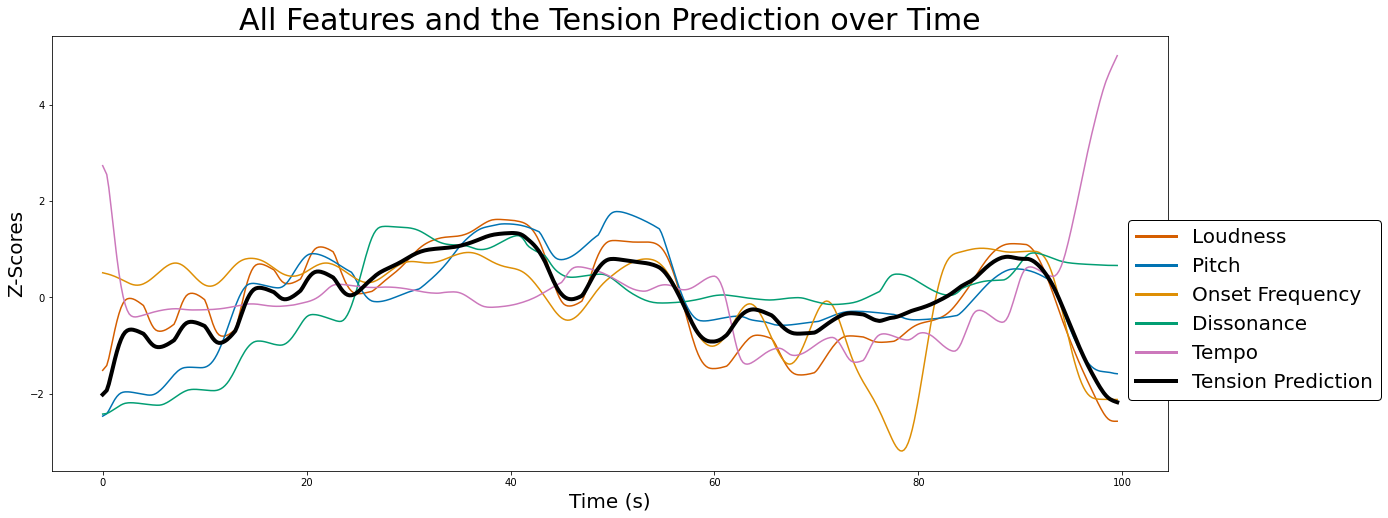

In [7]:
###Time Scale Model

tension_windows, feature_slopes = tension_prediction(df_features, model_variant = "time_scale")

plot_tension_and_features_10Hz(tension_windows, feature_slopes)

We see that the prediction from the weighted model follows the slopes for loudness slighlty more closely than the prediction from the time scale model. 
The slopes for tempo and dissonance loose some fluctuations in the time scale model, which is due to the long memory window sizes. 

### 4. Overlap with the Behavioral Tension Ratings

Finally, we will assess the overlap with our behavioral tension ratings. 

In [8]:
#Loading the behavioral data (standardized and sampled at 10 Hz)
dat_mozart = pd.read_csv("data_filter/Mozart.csv")

dat_mozart = dat_mozart.fillna(0)
dat_mozart['ratings_smooth'] = uniform_filter1d(dat_mozart['mean_tension'], size =int(len(dat_mozart)/30)) 


Now we plot the mean tension ratings as well as our tension predictions from both model configurations. 

Text(0, 0.5, 'Z-Scores')

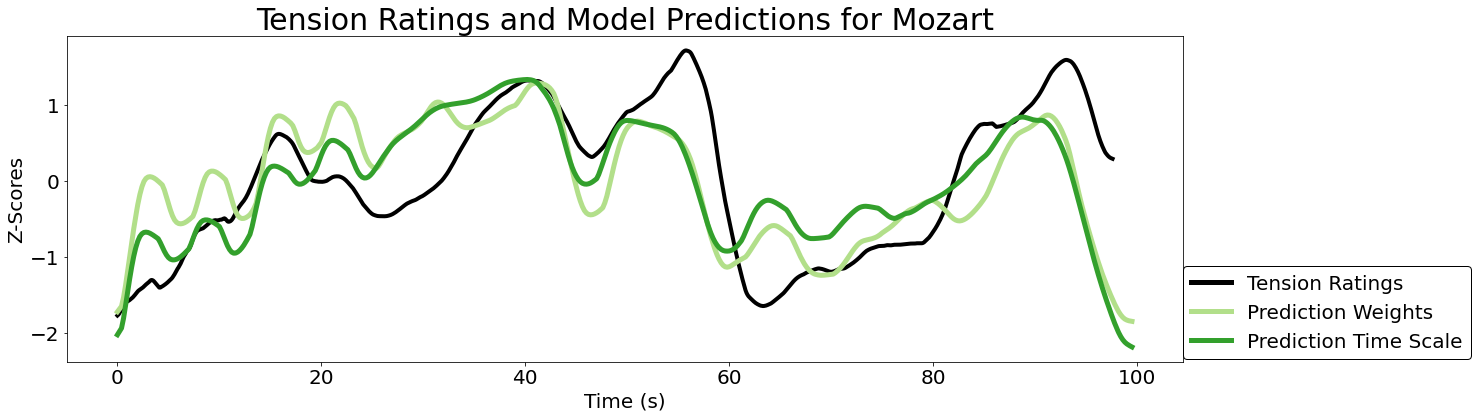

In [9]:
custom_lines = []
methods = ['Tension Ratings','Prediction Weights', 'Prediction Time Scale']

plt.figure(figsize = [20,6])
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


piece = 'Mozart'

###Ratings
plt.plot(dat_mozart['time'], dat_mozart['ratings_smooth'].shift(-45), color = "black", linewidth = 4)
custom_lines.append(Line2D([0], [0], color = 'black', lw = 5))


##Predictions
plt.plot(tension_weights['time'], tension_weights['tension_prediction'], color = sns.color_palette("Paired")[2], 
        linewidth = 5)
custom_lines.append(Line2D([0], [0], color = sns.color_palette("Paired")[2], lw = 5))
plt.plot(tension_windows['time'], tension_windows['tension_prediction'], color = sns.color_palette("Paired")[3], 
        linewidth = 5)
custom_lines.append(Line2D([0], [0], color = sns.color_palette("Paired")[3], lw = 5))


#Legend
plt.legend(custom_lines, methods , 
           loc='right', bbox_to_anchor=(1.267, 0.15), fancybox=True, facecolor='white', framealpha=1, 
          edgecolor = "black", fontsize = 20)


##Labels
plt.title("Tension Ratings and Model Predictions for Mozart", fontsize = 30)
plt.xlabel("Time (s)", fontsize = 20)
plt.ylabel("Z-Scores", fontsize = 20)

The correlations for all pieces as well as details on the procedure of the model optimization can be found in the publication.